In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
from torch.optim.lr_scheduler import StepLR

from model import EfficientNet_B0
from efficientnet_pytorch import EfficientNet

from torchvision import transforms

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
os.listdir('../data')

['cifar-10-batches-py', 'cifar-10-python.tar.gz']

In [21]:
batch = 256

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Resnet18

In [35]:
def train_cifar(classifier, optimizer, trainloader, testloader, epochs=100, print_freq=1, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_losses = []
    test_losses = []
    test_acc = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        #training
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*len(inputs)

        #testing
        correct = 0
        total = 0
        test_loss = 0
        for data in testloader:
            with torch.no_grad():
                images, labels = data[0].to(device), data[1].to(device)
                outputs = classifier(images)
                test_loss += loss.item()*len(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_losses.append(running_loss/50000)
        test_losses.append(test_loss/10000)
        test_acc.append(correct/total)
        #test every 'print_freq' epochs
        if epoch % print_freq == 0:
            print(f'epoch: {epoch+1}/{epochs}, train loss: {train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}, test acc: {correct/total:.4f}')
    return train_losses, test_losses, test_acc, classifier

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = models.resnet18(pretrained=False)
classifier.fc = nn.Linear(512, len(classes))
classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)

In [37]:
%timeit
train_losses, test_losses, test_acc, classifier = train_cifar(classifier, optimizer, trainloader, testloader,
                                                    epochs=10, print_freq=1)

epoch: 1/10, train loss: 1.7936, test loss: 1.5044, test acc: 0.4519
epoch: 2/10, train loss: 1.4289, test loss: 1.3717, test acc: 0.4982
epoch: 3/10, train loss: 1.2883, test loss: 1.2926, test acc: 0.5316
epoch: 4/10, train loss: 1.1869, test loss: 1.2451, test acc: 0.5461
epoch: 5/10, train loss: 1.1031, test loss: 1.1986, test acc: 0.5695
epoch: 6/10, train loss: 1.0210, test loss: 1.1534, test acc: 0.5889
epoch: 7/10, train loss: 0.9560, test loss: 1.1380, test acc: 0.5955
epoch: 8/10, train loss: 0.8918, test loss: 1.1177, test acc: 0.6049
epoch: 9/10, train loss: 0.8336, test loss: 1.0899, test acc: 0.6183
epoch: 10/10, train loss: 0.7756, test loss: 1.0956, test acc: 0.6193


In [41]:
def plot_history(train_losses,test_losses,test_acc,saveto):
    # Plot the loss function and train / validation accuracies
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(test_acc, label='train')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.show()
    plt.savefig(saveto)

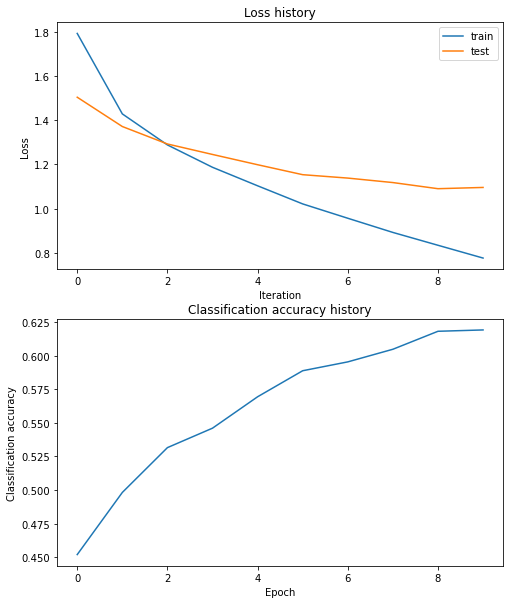

<Figure size 432x288 with 0 Axes>

In [42]:
plot_history(train_losses, test_losses, test_acc, saveto='../save_plot/resnet18.png')